In [1]:
import scanpy as sc
import numpy as np

def preprocess_and_cluster_adata(adata):
    """
    Preprocess and cluster an AnnData object using the Leiden algorithm.
    
    Parameters:
    adata (AnnData): Annotated data matrix.
    
    Returns:
    adata (AnnData): Annotated data matrix with clustering results.
    """
    # Filter cells with fewer than 200 genes and genes detected in fewer than 3 cells
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    # Calculate mitochondrial gene fraction
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
    
    # Normalize total counts per cell
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Logarithmize the data
    sc.pp.log1p(adata)
    
    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata.raw = adata
    adata = adata[:, adata.var['highly_variable']]
    sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

    
    # Scale the data to unit variance and zero mean
    sc.pp.scale(adata, max_value=10)
    
    # Perform PCA
    sc.tl.pca(adata, svd_solver='arpack')
    
    # Compute the neighborhood graph of cells
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    # sc.tl.paga(adata)
    # sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
    # sc.tl.umap(adata, init_pos='paga')
    # sc.tl.umap(adata)

    # Perform clustering using the Leiden algorithm
    sc.tl.leiden(
        adata,
        resolution=0.9,
        random_state=0,
        n_iterations=2,
        directed=False,
    )
    
    return adata

# Example usage:
# adata = sc.datasets.pbmc3k()  # Load example dataset
# adata = preprocess_and_cluster_adata(adata)
# print(adata.obs['leiden'].head())  # Print the first few clusters


/home/icb/fatemehs.hashemig/miniconda3/envs/interpretable-ssl/lib/python3.12/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


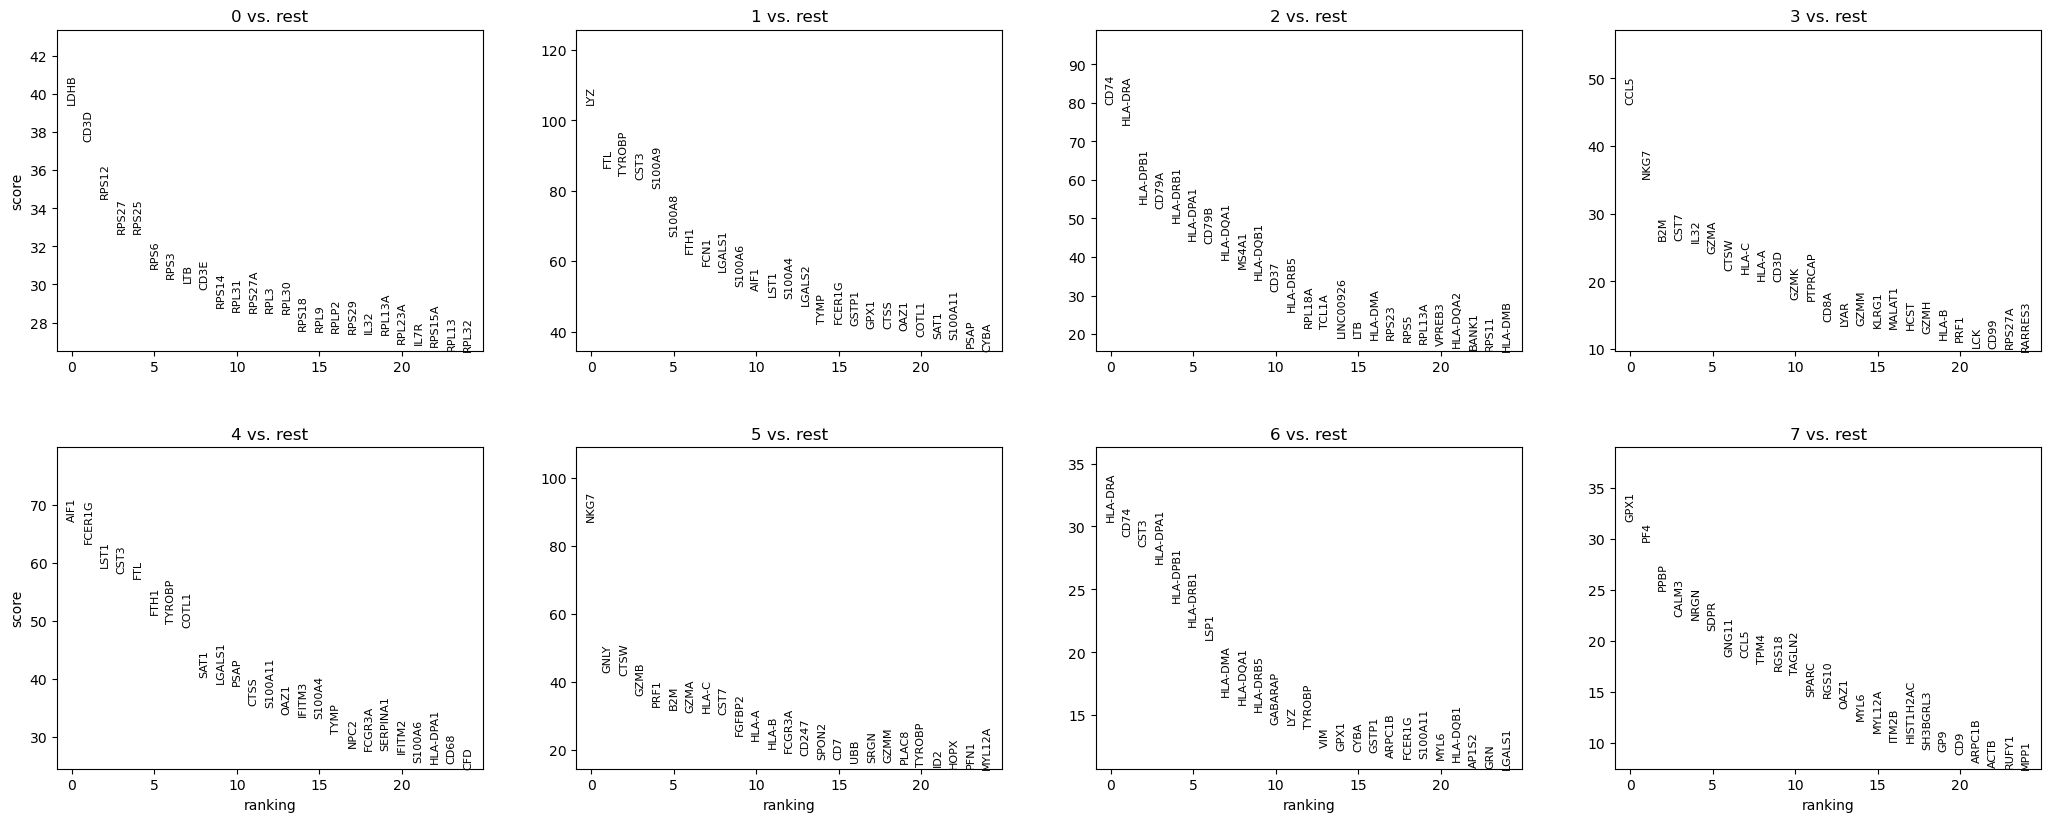

In [2]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)
adata = preprocess_and_cluster_adata(adata)
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [4]:
import pandas as pd
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7
0,LDHB,LYZ,CD74,CCL5,AIF1,NKG7,HLA-DRA,GPX1
1,CD3D,FTL,HLA-DRA,NKG7,FCER1G,GNLY,CD74,PF4
2,RPS12,TYROBP,HLA-DPB1,B2M,LST1,CTSW,CST3,PPBP
3,RPS27,CST3,CD79A,CST7,CST3,GZMB,HLA-DPA1,CALM3
4,RPS25,S100A9,HLA-DRB1,IL32,FTL,PRF1,HLA-DPB1,NRGN
